In [1]:
import tensorflow
tensorflow.__version__

'2.5.0'

In [2]:
import keras
keras.__version__

Using TensorFlow backend.


'2.5.0'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
from math import sin, cos, pi
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Conv2D, LeakyReLU, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Sequential


from tensorflow.keras.layers import Activation,Convolution2D,MaxPooling2D,BatchNormalization,Flatten,Dense,Dropout,Conv2D,MaxPool2D,ZeroPadding2D

import glob
import xml.etree.ElementTree as ET


## Convert XML to CSV

In [4]:
def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            bbx = member.find('bndbox')
            xmin = int(bbx.find('xmin').text)
            ymin = int(bbx.find('ymin').text)
            xmax = int(bbx.find('xmax').text)
            ymax = int(bbx.find('ymax').text)
            label = member.find('name').text

            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     label,
                     xmin,
                     ymin,
                     xmax,
                     ymax
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df


def main():

    image_path = os.path.join(os.getcwd(), 'train')
    print(image_path)
    xml_df = xml_to_csv(image_path)
    xml_df.to_csv('labels.csv', index=None)
    print('Successfully converted xml to csv.')


main()

/Users/darshilmodi/Desktop/Personal/AI/Computer Vision/train
Successfully converted xml to csv.


## Loading keypoints CSV

In [5]:
req_images = pd.read_csv('labels.csv')
fin_images = req_images.drop_duplicates(subset='filename', keep="last") 

In [6]:
fin_images.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,01FKX0XKBPBGVMVWYC2QHD1WQT.jpeg,800,600,bottle,251,339,604,594
1,01FKX0R745QEBN7HFMX453S4ZR.jpeg,800,600,bottle,341,3,565,436
2,01FKX0SW83QD84ZJBCAEAWCZDC.jpeg,800,600,bottle,297,114,562,531
3,01FKX0ZMV9S7AFWVG74Q87JPZ5.jpeg,800,600,bottle,157,3,466,546
4,01FKX0RSMAHQESF8SX2238PMSS.jpeg,800,600,bottle,372,18,571,492


## Generate images for X

In [7]:
def generate_images():
    
    source_images = fin_images['filename'].to_list()
    
    images = []
   
    for i in source_images:
        path = 'train/'+i
        input_image = cv2.imread(path)
        input_image = cv2.resize(input_image,(96,96))
        images.append(input_image)
#         cv2.imwrite('img_t.jpg',input_image)
    
    images = np.array(images)
    print('images_shape:',images.shape)
    return images, source_images

In [8]:
model_input_images, source_images = generate_images()

images_shape: (159, 96, 96, 3)


## Normalizing image box points with respect to model input

In [9]:
fin_images['width_ratio'] = fin_images['width']/96
fin_images['height_ratio'] = fin_images['height']/96

fin_images['xmin'] = fin_images['xmin']/fin_images['width_ratio']
fin_images['xmax'] = fin_images['xmax']/fin_images['width_ratio']
fin_images['ymin'] = fin_images['ymin']/fin_images['height_ratio']
fin_images['ymax'] = fin_images['ymax']/fin_images['height_ratio']

In [10]:
fin_images.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,width_ratio,height_ratio
0,01FKX0XKBPBGVMVWYC2QHD1WQT.jpeg,800,600,bottle,30.12,54.24,72.48,95.04,8.333333,6.25
1,01FKX0R745QEBN7HFMX453S4ZR.jpeg,800,600,bottle,40.92,0.48,67.80,69.76,8.333333,6.25
2,01FKX0SW83QD84ZJBCAEAWCZDC.jpeg,800,600,bottle,35.64,18.24,67.44,84.96,8.333333,6.25
3,01FKX0ZMV9S7AFWVG74Q87JPZ5.jpeg,800,600,bottle,18.84,0.48,55.92,87.36,8.333333,6.25
4,01FKX0RSMAHQESF8SX2238PMSS.jpeg,800,600,bottle,44.64,2.88,68.52,78.72,8.333333,6.25


## Generating keypoints for Y

In [11]:

def generate_keypoints():
    
    keypoint_features = []
    
    
    for i in source_images:
        try:
            print(i)
            image_name = i
            mask = fin_images[fin_images['filename'] == image_name]
            mask = mask.values.tolist()
            print(mask)
            keypoints = (mask[0][4:8])
            #print(keypoints)
            newList = [int(x) / 96 for x in keypoints]
            #print(newList)
            keypoint_features.append(newList)
        except:
            print('error !')
    keypoint_features = np.array(keypoint_features, dtype=float)    
    return keypoint_features


In [12]:
model_input_keypoints = generate_keypoints()

01FKX0XKBPBGVMVWYC2QHD1WQT.jpeg
[['01FKX0XKBPBGVMVWYC2QHD1WQT.jpeg', 800, 600, 'bottle', 30.119999999999997, 54.24, 72.47999999999999, 95.04, 8.333333333333334, 6.25]]
01FKX0R745QEBN7HFMX453S4ZR.jpeg
[['01FKX0R745QEBN7HFMX453S4ZR.jpeg', 800, 600, 'bottle', 40.919999999999995, 0.48, 67.8, 69.76, 8.333333333333334, 6.25]]
01FKX0SW83QD84ZJBCAEAWCZDC.jpeg
[['01FKX0SW83QD84ZJBCAEAWCZDC.jpeg', 800, 600, 'bottle', 35.64, 18.24, 67.44, 84.96, 8.333333333333334, 6.25]]
01FKX0ZMV9S7AFWVG74Q87JPZ5.jpeg
[['01FKX0ZMV9S7AFWVG74Q87JPZ5.jpeg', 800, 600, 'bottle', 18.84, 0.48, 55.919999999999995, 87.36, 8.333333333333334, 6.25]]
01FKX0RSMAHQESF8SX2238PMSS.jpeg
[['01FKX0RSMAHQESF8SX2238PMSS.jpeg', 800, 600, 'bottle', 44.63999999999999, 2.88, 68.52, 78.72, 8.333333333333334, 6.25]]
01FKX0VKJ11JCVEK29MXYBDD4Z.jpeg
[['01FKX0VKJ11JCVEK29MXYBDD4Z.jpeg', 800, 600, 'bottle', 30.839999999999996, 0.16, 59.16, 94.88, 8.333333333333334, 6.25]]
01FKX0X61EQTN3MDWTQNH3FF29.jpeg
[['01FKX0X61EQTN3MDWTQNH3FF29.jpeg', 80

In [13]:
len(model_input_keypoints)

159

## Testing X and Y

In [14]:
model_input_keypoints[155]*96

array([21.,  0., 52., 84.])

In [15]:
im = model_input_images[155]
from PIL import Image
hm = Image.fromarray(im)
hm.save("your_file.jpeg")

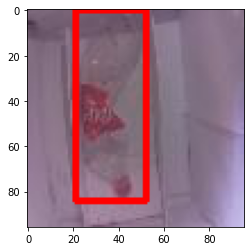

In [16]:
image = cv2.imread("your_file.jpeg")
out = cv2.rectangle(image, (21,0), (52, 84), (255,0,0), 2)
plt.imshow(out)

##  Model architechture

In [17]:
input_shape = (96,96,3)
no_of_keypoints = 4  #xmin,ymin,xmax,ymax



model = Sequential()

# Input dimensions: (None, 96, 96, 1)
model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=input_shape))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
# Input dimensions: (None, 96, 96, 32)
model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Input dimensions: (None, 48, 48, 32)
model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
# Input dimensions: (None, 48, 48, 64)
model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Input dimensions: (None, 24, 24, 64)
model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
# Input dimensions: (None, 24, 24, 96)
model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Input dimensions: (None, 12, 12, 96)
model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
# Input dimensions: (None, 12, 12, 128)
model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Input dimensions: (None, 6, 6, 128)
model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
# Input dimensions: (None, 6, 6, 256)
model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Input dimensions: (None, 3, 3, 256)
model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
# Input dimensions: (None, 3, 3, 512)
model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

# Input dimensions: (None, 3, 3, 512)
model.add(Flatten())
model.add(Dense(512,activation='linear'))
model.add(Dropout(0.3))
model.add(Dense(no_of_keypoints))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        864       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 32)        9216      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0

In [18]:
import os
from keras.callbacks import ModelCheckpoint

checkpoint_path = "N_21oct/cp-{epoch:03d}.pkl"
checkpoint_dir = os.path.dirname(checkpoint_path)

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min', 
    save_best_only=False)

In [19]:
len(model_input_keypoints)

159

In [20]:
#model.load_weights('BN_13oct/cp-175.pkl')

In [21]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlyStopping = EarlyStopping(monitor='loss', patience=30, mode='min',
                             baseline=None)


rlp = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=5, min_lr=1e-15, mode='min', verbose=1)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

history = model.fit(model_input_images, model_input_keypoints, epochs=100, batch_size=64)


2021-11-07 20:51:23.764337: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-07 20:51:23.764603: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/100
3/3 [==============================] - 3s 673ms/step - loss: 488.3423 - mse: 488.3423
Epoch 2/100
3/3 [==============================] - 2s 667ms/step - loss: 46.6011 - mse: 46.6011
Epoch 3/100
3/3 [==============================] - 2s 661ms/step - loss: 26.1818 - mse: 26.1818
Epoch 4/100
3/3 [==============================] - 2s 665ms/step - loss: 16.3252 - mse: 16.3252
Epoch 5/100
3/3 [==============================] - 2s 662ms/step - loss: 13.6545 - mse: 13.6545
Epoch 6/100
3/3 [==============================] - 2s 666ms/step - loss: 9.3965 - mse: 9.3965
Epoch 7/100
3/3 [==============================] - 2s 669ms/step - loss: 7.8421 - mse: 7.8421
Epoch 8/100
3/3 [==============================] - 2s 671ms/step - loss: 6.5241 - mse: 6.5241
Epoch 9/100
3/3 [==============================] - 2s 685ms/step - loss: 5.0846 - mse: 5.0846
Epoch 10/100
3/3 [==============================] - 2s 714ms/step - loss: 4.8002 - mse: 4.8002
Epoch 11/100
3/3 [=============================

3/3 [==============================] - 3s 808ms/step - loss: 1.8048 - mse: 1.8048
Epoch 88/100
3/3 [==============================] - 3s 802ms/step - loss: 2.3355 - mse: 2.3355
Epoch 89/100
3/3 [==============================] - 3s 813ms/step - loss: 1.7518 - mse: 1.7518
Epoch 90/100
3/3 [==============================] - 3s 810ms/step - loss: 1.6351 - mse: 1.6351
Epoch 91/100
3/3 [==============================] - 3s 821ms/step - loss: 2.4520 - mse: 2.4520
Epoch 92/100
3/3 [==============================] - 3s 817ms/step - loss: 1.7220 - mse: 1.7220
Epoch 93/100
3/3 [==============================] - 3s 818ms/step - loss: 1.8215 - mse: 1.8215
Epoch 94/100
3/3 [==============================] - 3s 815ms/step - loss: 1.7818 - mse: 1.7818
Epoch 95/100
3/3 [==============================] - 3s 817ms/step - loss: 2.0069 - mse: 2.0069
Epoch 96/100
3/3 [==============================] - 3s 818ms/step - loss: 2.5063 - mse: 2.5063
Epoch 97/100
3/3 [==============================] - 3s 825ms/st

## Testing Model on Images 

In [29]:
image_test = "test2.jpeg"
test_image = cv2.imread(image_test)
test_image = cv2.resize(test_image,(96,96))
cv2.imwrite('final_test1.jpg',test_image)
images = np.array(test_image)/255.0

print(images.shape)
testt=np.expand_dims(images,axis=0)
print(testt.shape)

ans = model.predict(testt)
print(abs(ans))

ans = abs(ans) * 96  #denormalizing
print(ans)

(96, 96, 3)
(1, 96, 96, 3)
[[0.9005428  1.9351654  0.58995867 1.8765978 ]]
[[ 86.45211  185.77588   56.636032 180.15338 ]]


True

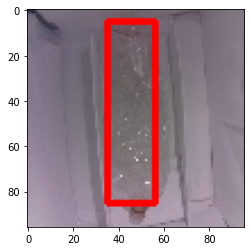

In [30]:
test_image = cv2.imread('final_test1.jpg')
test_image = cv2.resize(test_image,(96,96))
out = cv2.rectangle(test_image, (ans[0],ans[1]), (ans[2],ans[3]), (255,0,0), 2)
plt.imshow(out)
cv2.imwrite('final_test.jpg',out)

In [14]:
def convert_coco_json_to_csv(filename):
    import pandas as pd
    import json
    
    # COCO2017/annotations/instances_val2017.json
    s = json.load(open(filename, 'r'))
    out_file = filename[:-5] + '.csv'
    out = open(out_file, 'w')
    out.write('id,x1,y1,x2,y2,label\n')

    all_ids = []
    for im in s['images']:
        all_ids.append(im['file_name'])

    all_ids_ann = []
    for ann in s['annotations']:
        image_id = ann['image_id']
        all_ids_ann.append(image_id)
        x1 = ann['bbox'][0]
        x2 = ann['bbox'][0] + ann['bbox'][2]
        y1 = ann['bbox'][1]
        y2 = ann['bbox'][1] + ann['bbox'][3]
        label = ann['category_id']
        out.write('{},{},{},{},{},{}\n'.format(image_id, x1, y1, x2, y2, label))

    all_ids = set(all_ids)
    all_ids_ann = set(all_ids_ann)
    no_annotations = list(all_ids - all_ids_ann)
    # Output images without any annotations
    for image_id in no_annotations:
        out.write('{},{},{},{},{},{}\n'.format(image_id, -1, -1, -1, -1, -1))
    out.close()

    # Sort file by image id
    s1 = pd.read_csv(out_file)
    s1.sort_values('id', inplace=True)
    s1.to_csv(out_file, index=False)


In [15]:
convert_coco_json_to_csv('train.json')